<a href="https://colab.research.google.com/github/noahruiz416/Tempe_Traffic_Classification/blob/main/Tempe_Traffic_Prototype_Feature_Engineering_Model_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook will contain the initial feature engineering approaches that will be used. Decisions to transform or change certain varaibles will be explained

In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sns

In [ ]:
df = pd.read_csv("traffic_data.2.csv")

#### Based on Exploratory Analysis, I plan on combining certain features that are very similar. Additionally I may exclude certain variables as well. More in depth reasoning will be included in final report.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#### This first set of functions are to be used as needed, depending on the model being ran

In [ ]:
#function to binary encode accidents as fatal or nonfatal
def encode_fatal_accidents(data):
  Severity = []
  for row in data['Injuryseverity']:
    if row != "Fatal":
      Severity.append(0) #nonfatal
    if row == "Fatal":
      Severity.append(1) #fatal
  data['Fatal_Non_Fatal'] = Severity

#this function turns our categorical variables into dummy variables
def nominal_encoding(data):
  data = [['StreetName','Collisionmanner', 'Lightcondition', 'Weather', 'SurfaceCondition']] 
  data_dummies = pd.get_dummies(data)
  return data_dummies

def drop_useless_cols(data):
  return_data = data.drop(labels = ['X', 'Y',
                      'Incidentid', 'DateTime', 'Year',
                       'Latitude', 'Longitude', 'Totalinjuries',
                       'Totalfatalities', 'Injuryseverity', 'Distance', 'OBJECTID', 'Age_Drv1', 'Age_Drv2'], axis = 1)
  return return_data

In [ ]:
#helper function that contains the logic for whether or not drugs were involved in an accident
def label_drugs(row):
  if row['DrugUse_Drv1'] == "Drugs" or row['DrugUse_Drv2'] == "Drugs":
    return 1 #drugs are involved
  if row['DrugUse_Drv1'] != "Drugs" or row['DrugUse_Drv2'] != "Drugs":
    return 0 #drugs are not involved

#helper function that contains the logic for whether or not alch was involved in an accident
def label_alchol(row):
  if row['AlcoholUse_Drv1'] == "Drugs" or row['AlcoholUse_Drv2'] == "Drugs":
    return 1 #drugs are involved
  if row['AlcoholUse_Drv1'] != "Drugs" or row['AlcoholUse_Drv2'] != "Drugs":
    return 0 #drugs are not involved

def apply_drug_alchol_label(input_data):
  data1 = input_data['drugs_involved'] = input_data.apply (lambda row: label_drugs(row), axis=1)
  data1 = input_data['alcohol_involved'] = input_data.apply (lambda row: label_alchol(row), axis=1)


#### These functions are a part of basic data cleaning and will be used for all train datasets regardless of the model

In [ ]:
#this function drops bad columns in light conditions, violations and collisionmanner
def drop_useless_rows(input_data):
  data1 = input_data[input_data['Lightcondition'].str.contains("51")==False]
  data2 = data1[data1['Lightcondition'].str.contains("Unknown 51")==False]
  data3 = data2[data2['Violation1_Drv1'].str.contains("108")==False]
  data4 = data3[data3['Violation1_Drv1'].str.contains("109")==False]
  data5 = data4[data4['Violation1_Drv1'].str.contains("49")==False]
  data6 = data5[data5['Collisionmanner'].str.contains("10")==False]
  return data6

In [ ]:
#this function removes outlier driving ages in the data_set and then calculates the median age between the two drivers and creates a new column
def age_manipulation(input_data):
  data = input_data.drop(input_data.index[input_data['Age_Drv1'] >= 100], inplace=False)
  data1 = data.drop(data.index[data['Age_Drv2'] >= 100], inplace=False)
  data1['median_age'] = (data1['Age_Drv1'] + data1['Age_Drv2']) / 2
  return data1


In [ ]:
#function to call all the cleaning methods at once
def clean_dataset(input_data):
  input_data_rows_dropped = drop_useless_rows(input_data)
  age_manipulated_data = age_manipulation(input_data_rows_dropped)
  return age_manipulated_data

In [ ]:
#the encode function simply creates our binary labels for fatal or non fatal accidents
encode_fatal_accidents(df)
clean_dat = clean_dataset(df)
clean_dat2_all = drop_useless_cols(clean_dat)
apply_drug_alchol_label(clean_dat2_all)
clean_dat2_all.dropna(inplace=True)

input_vector = clean_dat2_all.drop(labels = ['Fatal_Non_Fatal'], axis = 1)


#we then load the data into to different dataframes one with our input vector and the other with train/test labels
X = input_vector
y = clean_dat2_all['Fatal_Non_Fatal']

#### With our Dataset clean we can start our modeling, Model V1 Baseline Logistc. The main issue that arises, is that our model  classifies negatives properly but since to severe imbalance it does not classify true positives at all.

In [ ]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant

X_ohe = pd.get_dummies(X)

x1_train, x1_test, y1_train, y1_test = train_test_split(X_ohe, y, random_state=0, test_size = .20)

In [ ]:
logit_lasso = LogisticRegressionCV(cv=5, random_state=0, penalty = "l1", solver='liblinear').fit(x1_train, y1_train)

In [ ]:
coef_table = pd.DataFrame(list(x1_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",logit_lasso.coef_.transpose())

In [ ]:
#having a logistc regression model that is OHE with all variables, gives very poor results and almost all coefficients are shrunk to zero 
coef_table_sorted = coef_table.sort_values(by = 'Coefs', ascending = False)

In [ ]:
display(coef_table_sorted)

,0,Coefs
555,CrossStreet_I-10 Exit 157 A-Ramp,0.000000
738,CrossStreet_S Juniper St,0.000000
744,CrossStreet_SR-101 Cardinal Frontage,0.000000
743,CrossStreet_S Roosevelt St,0.000000
742,CrossStreet_S Poplar St,0.000000
...,...,...
375,CrossStreet_Arizona Grand Pkwy,0.000000
376,CrossStreet_Arizona Mills,0.000000
377,CrossStreet_Arizona Mills Access E,0.000000
378,CrossStreet_Arizona Mills Access N,0.000000


In [ ]:
#we have good accuracy performance however, we must also check the confusion matrix for positive classification performance
logit_lasso.score(x1_train, y1_train)

0.9975696319728417

In [ ]:
logit_lasso.score(x1_test, y1_test)

0.997685542354575

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay

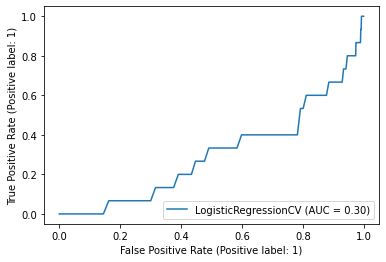

In [ ]:
#from this ROC curve we can see that our model performs horribly with true positive rates
RocCurveDisplay.from_estimator(logit_lasso, x1_test, y1_test)

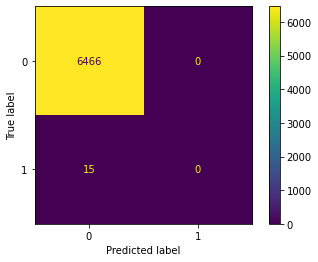

In [ ]:
ConfusionMatrixDisplay.from_estimator(logit_lasso, x1_test, y1_test)

input_vector### In order to correct for these issues it may be smart to deal with the large imbalance within the training data. To do so we will use a combination of resampling and imputation to create new positive values. But first we will try two different encoding methods to see if baseline performance improves

In [ ]:
X = input_vector
y = clean_dat2_all['Fatal_Non_Fatal']

x1_train, x1_test, y1_train, y1_test = train_test_split(X, y, random_state=0, test_size = .20)

In [ ]:
from category_encoders import CountEncoder
from category_encoders import SumEncoder

#train first
#splitting cat and numerical features
cat_features_input = x1_train.select_dtypes(['object'])
numerical_features_input = x1_train.select_dtypes(['int', 'float'])

#encoding cat_features
encdoer = CountEncoder(return_df = True)
cat_features_input_encoded = encdoer.fit_transform(cat_features_input)

#concat df back together
x1_train = pd.concat([numerical_features_input, cat_features_input_encoded], axis =1)

In [ ]:
#processing test data
cat_features_input_test = x1_test.select_dtypes(['object'])
numerical_features_input_test = x1_test.select_dtypes(['int', 'float'])

#encoding cat_features
cat_features_input_encoded_test = encdoer.fit_transform(cat_features_input_test)

#concat df back together
x1_test = pd.concat([numerical_features_input_test, cat_features_input_encoded_test], axis =1)

In [ ]:
#training whole input vector to check predictions (will use later)
cat_features_input_whole = X.select_dtypes(['object'])
numerical_features_input_whole = X.select_dtypes(['int', 'float'])

#encoding cat_features
cat_features_input_encoded_whole = encdoer.fit_transform(cat_features_input_whole)

#concat df back together
X = pd.concat([numerical_features_input_whole, cat_features_input_encoded_whole], axis =1)

In [ ]:
#now we will train the same baseline model on the encoded input vector
logit_lasso = LogisticRegressionCV(cv=5, random_state=0, penalty = "l1", solver='liblinear').fit(x1_train, y1_train)

In [ ]:
coef_table = pd.DataFrame(list(x1_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",logit_lasso.coef_.transpose())

In [ ]:
coef_table.sort_values(by = 'Coefs', ascending = False).head(10)

,0,Coefs
1,drugs_involved,1.140401
0,median_age,0.064393
3,StreetName,0.000298
14,Violation1_Drv1,0.000171
11,Gender_Drv1,0.000139
12,Traveldirection_One,0.000114
18,Gender_Drv2,0.000089
4,CrossStreet,0.000068
20,Unitaction_Two,0.000039
19,Traveldirection_Two,0.000026


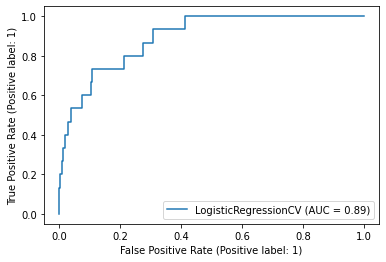

In [ ]:
#performance significantly increases using the frequency encoding method even on the test dataset
RocCurveDisplay.from_estimator(logit_lasso, x1_test, y1_test)

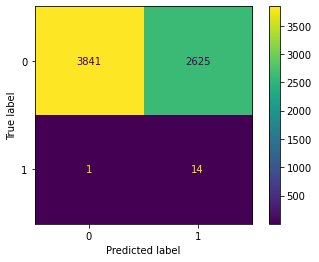

In [ ]:
ConfusionMatrixDisplay.from_estimator(logit_lasso, x1_test, y1_test)

In [ ]:
logit_lasso.score(x1_test, y1_test)

0.5948156148742478

In [ ]:
from sklearn.metrics import recall_score

y_true = y
y_pred = logit_lasso.predict(X)

precision_score_logit = precision_score(y_true, y_pred)
recall_score_logit = recall_score(y_true, y_pred)

In [ ]:
#very high amount of false negatives
recall_score_logit

0.05128205128205128

In [ ]:
#solid amount of true positives, when compared to baseline 
precision_score_logit

0.8

### Now that we have seen a drastic improvement with Count Encoding, we will use this as the preffered method for now. Now we will do the following. 

1. Establish several pipelines for models to use 
2. Train and test each model/pipeline 
3. Choose the best out of the box model
4. Fine tune the best out of the box model

For now we will iterate through the following models: 
- Logistic Regression 
- SVM 
- Random Forest

In [ ]:
x1_train, x1_test, y1_train, y1_test = train_test_split(X, y, random_state=0, test_size = .20)

cat_features_input = x1_train.select_dtypes(['object'])
numerical_features_input = x1_train.select_dtypes(['int', 'float'])

#encoding cat_features
encdoer = CountEncoder(return_df = True)
cat_features_input_encoded = encdoer.fit_transform(cat_features_input)

#concat df back together
x1_train = pd.concat([numerical_features_input, cat_features_input_encoded], axis =1)

#processing test data
cat_features_input_test = x1_test.select_dtypes(['object'])
numerical_features_input_test = x1_test.select_dtypes(['int', 'float'])

#encoding cat_features
cat_features_input_encoded_test = encdoer.fit_transform(cat_features_input_test)

#concat df back together
x1_test = pd.concat([numerical_features_input_test, cat_features_input_encoded_test], axis =1)

#training whole input vector to check predictions (will use later)
cat_features_input_whole = X.select_dtypes(['object'])
numerical_features_input_whole = X.select_dtypes(['int', 'float'])

#encoding cat_features
cat_features_input_encoded_whole = encdoer.fit_transform(cat_features_input_whole)

#concat df back together
X = pd.concat([numerical_features_input_whole, cat_features_input_encoded_whole], axis =1)

In [ ]:
pipeline_randomforest= Pipeline([('rf_classifier',RandomForestClassifier())])
pipeline_svc= Pipeline([('svm_classifier',SVC())])
pipeline_logistic= Pipeline([('lr_classifier',LogisticRegression(random_state=0))])

pipelines = [pipeline_randomforest, pipeline_svc, pipeline_logistic]

In [ ]:
for pipe in pipelines:
	pipe.fit(x1_train, y1_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
pred_rf = pipelines[0].predict(x1_test)
pred_scv = pipelines[1].predict(X)
pred_logit = pipelines[2].predict(X)

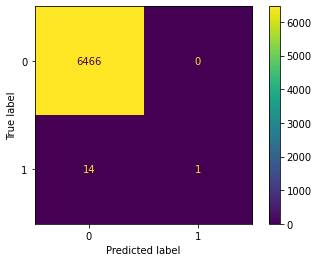

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipelines[0], x1_test, y1_test)

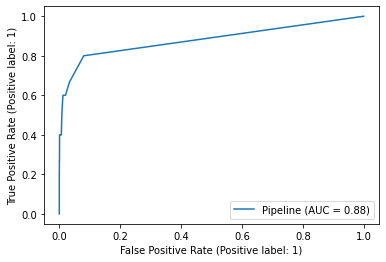

In [ ]:
RocCurveDisplay.from_estimator(pipelines[0], x1_test, y1_test)

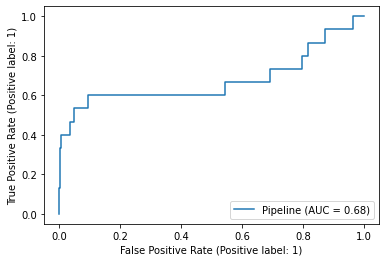

In [ ]:
RocCurveDisplay.from_estimator(pipelines[1], x1_test, y1_test)

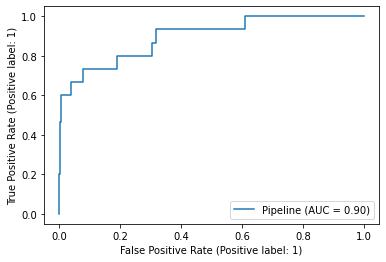

In [ ]:
RocCurveDisplay.from_estimator(pipelines[2], x1_test, y1_test)

In [ ]:
precision_score(y,pred_scv)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [ ]:
precision_score(y,pred_logit)

0.5454545454545454

#### From here it is clear that the Logistic and RF models work the best out of the box, still though due to the high imbalance in the dataset, it may be smart to use various resamping and augemntation methods which we will try now. Additionally we will try using the novel CatBoost Method, to test out of the box performance

In [ ]:
x1_train, x1_test, y1_train, y1_test = train_test_split(X, y, random_state=0, test_size = .20)

cat_features_input = x1_train.select_dtypes(['object'])
numerical_features_input = x1_train.select_dtypes(['int', 'float'])

#encoding cat_features
encdoer = CountEncoder(return_df = True)
cat_features_input_encoded = encdoer.fit_transform(cat_features_input)

#concat df back together
x1_train = pd.concat([numerical_features_input, cat_features_input_encoded], axis =1)

#processing test data
cat_features_input_test = x1_test.select_dtypes(['object'])
numerical_features_input_test = x1_test.select_dtypes(['int', 'float'])

#encoding cat_features
cat_features_input_encoded_test = encdoer.fit_transform(cat_features_input_test)

#concat df back together
x1_test = pd.concat([numerical_features_input_test, cat_features_input_encoded_test], axis =1)

#training whole input vector to check predictions (will use later)
cat_features_input_whole = X.select_dtypes(['object'])
numerical_features_input_whole = X.select_dtypes(['int', 'float'])

#encoding cat_features
cat_features_input_encoded_whole = encdoer.fit_transform(cat_features_input_whole)

#concat df back together
X = pd.concat([numerical_features_input_whole, cat_features_input_encoded_whole], axis =1)

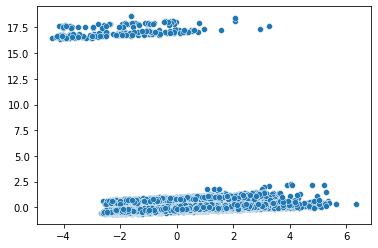

In [ ]:
#seeing if any interesting patterns can be deduced by PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
pca = PCA(n_components=2, svd_solver='full')

X_stnd = scale(X)

pca.fit(X_stnd)
reduced = pca.transform(X_stnd)

#Interstingly enough clusters do exist within the dataset, despite the low variability between principal components
sns.scatterplot(x = reduced[:, 0], y = reduced[:, 1])

In [ ]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=X.columns)
loading_matrix.sort_values(by = 'PC1', ascending = False)

,PC1,PC2
Unitaction_Two,1.564512e-01,2.909245e-02
median_age,1.251693e-01,-3.149609e-02
DrugUse_Drv1,1.210435e-01,-9.504170e-01
Gender_Drv2,6.627420e-02,5.692594e-02
CrossStreet,5.663692e-02,3.280685e-02
AlcoholUse_Drv1,3.803358e-02,-2.080118e-01
Gender_Drv1,2.975561e-02,6.217377e-02
alcohol_involved,1.615761e-16,3.953374e-17
DrugUse_Drv2,-3.020810e-03,-2.452091e-01
SurfaceCondition,-5.863303e-02,1.760002e-02


In [ ]:
#catboost time 
!pip install catboost

x1_train, x1_test, y1_train, y1_test = train_test_split(input_vector, y, random_state=0, test_size = .20)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
cat_features_input = x1_train.select_dtypes(['object']).columns

In [ ]:
from catboost import CatBoostClassifier, Pool, metrics, cv
catBoost = CatBoostClassifier()
categorical_features_indices = np.where(x1_train.dtypes != float)[0]


catBoost.fit(
    x1_train, y1_train, cat_features=categorical_features_indices, 
    plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.041359
0:	learn: 0.5759000	total: 102ms	remaining: 1m 42s
1:	learn: 0.4746421	total: 170ms	remaining: 1m 24s
2:	learn: 0.3952125	total: 193ms	remaining: 1m 4s
3:	learn: 0.3297284	total: 210ms	remaining: 52.4s
4:	learn: 0.2740999	total: 321ms	remaining: 1m 3s
5:	learn: 0.2278524	total: 395ms	remaining: 1m 5s
6:	learn: 0.1924427	total: 438ms	remaining: 1m 2s
7:	learn: 0.1635516	total: 488ms	remaining: 1m
8:	learn: 0.1398560	total: 552ms	remaining: 1m
9:	learn: 0.1201802	total: 662ms	remaining: 1m 5s
10:	learn: 0.1027492	total: 789ms	remaining: 1m 10s
11:	learn: 0.0897090	total: 825ms	remaining: 1m 7s
12:	learn: 0.0784464	total: 898ms	remaining: 1m 8s
13:	learn: 0.0688290	total: 1.01s	remaining: 1m 11s
14:	learn: 0.0603469	total: 1.13s	remaining: 1m 13s
15:	learn: 0.0538405	total: 1.22s	remaining: 1m 14s
16:	learn: 0.0487598	total: 1.23s	remaining: 1m 11s
17:	learn: 0.0444562	total: 1.26s	remaining: 1m 8s
18:	learn: 0.0401220	total: 1.35s	remaining: 1m 9s
19:	learn:

In [ ]:
pred_cat = catBoost.predict(x1_test)
y_true = y1_test

In [ ]:
precision_score(y_true,pred_cat)

1.0

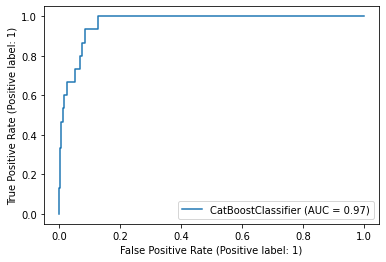

In [ ]:
RocCurveDisplay.from_estimator(catBoost, x1_test, y1_test)

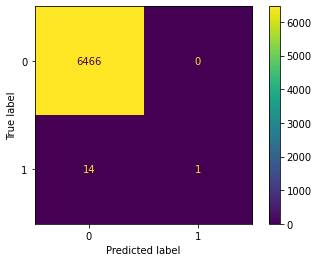

In [ ]:
ConfusionMatrixDisplay.from_estimator(catBoost, x1_test, y1_test)

In [ ]:
feature_importances = catBoost.get_feature_importance()
feature_names = x1_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

median_age: 26.216281660671832
CrossStreet: 8.709239170096659
Collisionmanner: 8.32488921212434
Violation1_Drv1: 7.33582316141425
Traveldirection_Two: 5.57688163755857
Unittype_One: 5.439695910172745
Unitaction_Two: 5.418635254408912
Unitaction_One: 4.944118421452197
Traveldirection_One: 4.730356949771582
StreetName: 4.229753457706172
JunctionRelation: 3.0899087797769287
Gender_Drv2: 2.8529624785112757
AlcoholUse_Drv1: 2.511013111903276
Lightcondition: 2.4774319093067847
Violation1_Drv2: 1.7089310779177485
AlcoholUse_Drv2: 1.3211165730673518
Weather: 1.2072659833679114
Unittype_Two: 1.1323524974287988
DrugUse_Drv2: 0.9300924668495678
drugs_involved: 0.9167868304636209
Gender_Drv1: 0.36925871402626087
SurfaceCondition: 0.3129915398715199
DrugUse_Drv1: 0.2442132021316107
alcohol_involved: 0.0


In [ ]:
##Random Over and UnderSampling with SMOTE, then apply Each Previous Algo we iterated through 
x1_train, x1_test, y1_train, y1_test = train_test_split(X, y, random_state=0, test_size = .20)

In [ ]:
pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from imblearn.under_sampling import NearMiss
nr = NearMiss()
  
X_train_miss, y_train_miss = nr.fit_resample(x1_train, y1_train.ravel())
  
print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape))
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape))
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1)))
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0)))

After Undersampling, the shape of train_X: (126, 24)
After Undersampling, the shape of train_y: (126,) 

After Undersampling, counts of label '1': 63
After Undersampling, counts of label '0': 63


In [ ]:
#training models with old pipelines 
for pipe in pipelines:
	pipe.fit(X_train_miss, y_train_miss)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


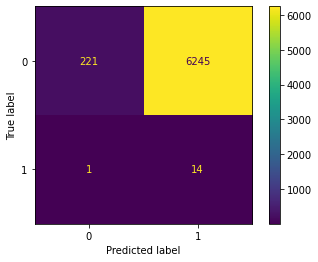

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipelines[0], x1_test, y1_test)

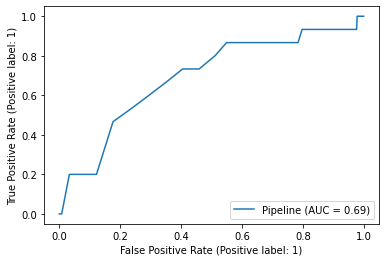

In [ ]:
RocCurveDisplay.from_estimator(pipelines[0], x1_test, y1_test)

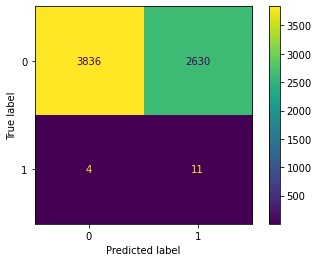

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipelines[1], x1_test, y1_test)

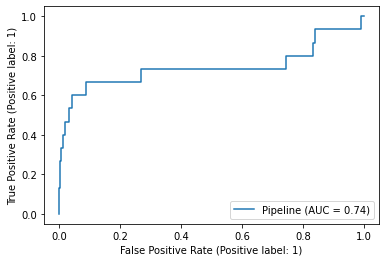

In [ ]:
RocCurveDisplay.from_estimator(pipelines[1], x1_test, y1_test)

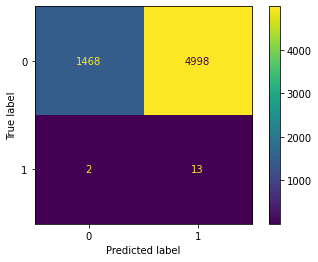

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipelines[2], x1_test, y1_test)

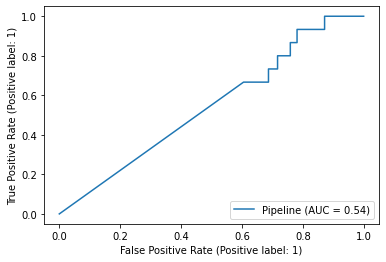

In [ ]:
RocCurveDisplay.from_estimator(pipelines[2], x1_test, y1_test)

In [ ]:
#SMOTE time
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)

x2_train, x2_test, y2_train, y2_test = train_test_split(X, y, random_state=0, test_size = .20)
X_train_smote, y_train_smote = sm.fit_resample(x2_train, y2_train.ravel())
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_smote.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_smote.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_smote == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_smote == 0)))

After OverSampling, the shape of train_X: (51718, 24)
After OverSampling, the shape of train_y: (51718,) 

After OverSampling, counts of label '1': 25859
After OverSampling, counts of label '0': 25859


In [ ]:
for pipe in pipelines:
	pipe.fit(X_train_smote, y_train_smote)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


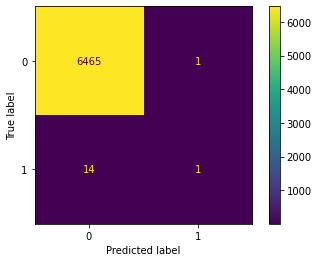

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipelines[0], x1_test, y1_test)

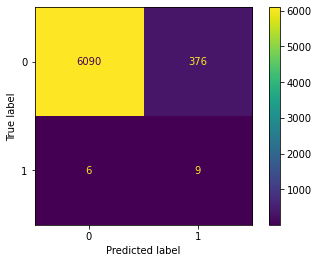

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipelines[1], x1_test, y1_test)

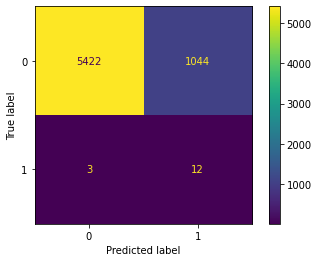

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipelines[2], x1_test, y1_test)

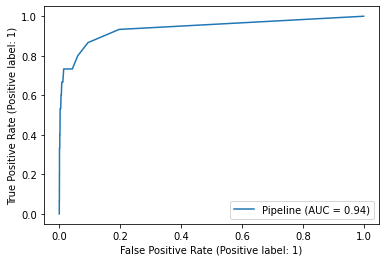

In [ ]:
RocCurveDisplay.from_estimator(pipelines[0], x1_test, y1_test)

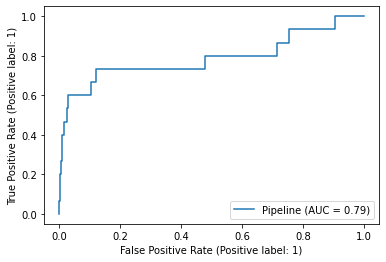

In [ ]:
RocCurveDisplay.from_estimator(pipelines[1], x1_test, y1_test)

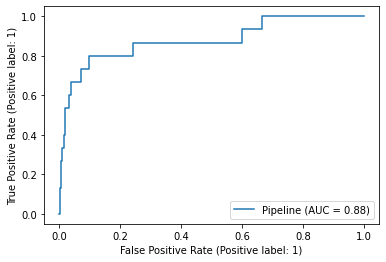

In [ ]:
RocCurveDisplay.from_estimator(pipelines[2], x1_test, y1_test)

In [ ]:
#Using SMOTE + Lasso Logistic Regression 
logit_lasso = LogisticRegressionCV(cv=5, random_state=0, penalty = "l1", solver='liblinear', max_iter=1000).fit(X_train_smote, y_train_smote)

In [ ]:
ConfusionMatrixDisplay.from_estimator(logit_lasso, x1_test, y1_test)

In [ ]:
RocCurveDisplay.from_estimator(logit_lasso, x1_test, y1_test)